In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append(os.path.join(os.path.dirname(""), os.pardir, os.pardir))
import coherence_analysis.utils as f

In [2]:
# generate 2d array of i.i.d. samples from a normal distribution
def generate_samples(n, m, mean=0, std=1):
    """
    Generate a 2D array of i.i.d. samples from a normal distribution.

    Parameters
    ----------
    n (int): Number of rows.
    m (int): Number of columns.
    mean (float): Mean of the normal distribution.
    std (float): Standard deviation of the normal distribution.

    Returns
    -------
    np.ndarray: 2D array of samples.
    """
    return np.random.normal(mean, std, size=(n, m))


def get_coherence_data(
    event_file_groups,
    basepath,
    group_index=-1,
    start_channel=0,
    end_channel=1000,
    num_sensors=1,
    end_sample=-1,
):
    file = basepath / event_file_groups[group_index][0]
    data, _ = f.load_brady_hdf5(file, normalize="no")
    print(f"Loading {file}")
    for a in range(1, len(event_file_groups[group_index]) - 1):
        file = basepath / event_file_groups[group_index][a]
        print(f"Loading {file}")
        data2, _ = f.load_brady_hdf5(file, normalize="no")
        data = np.append(data, data2, axis=1)

    file = basepath / event_file_groups[group_index][-1]
    print(f"Loading {file}")
    data2, _ = f.load_brady_hdf5(file, normalize="no")

    if end_sample == -1:
        data = np.append(data, data2, axis=1)
    else:
        data = np.append(data, data2[:, :end_sample], axis=1)
    coherence_data = data[
        start_channel : end_channel : int(
            (end_channel - start_channel) / num_sensors
        )
    ]

    return coherence_data

In [3]:
win_len = 5
overlap = 0
samples_per_sec = 1000

nsensors = 200

data = generate_samples(nsensors, 70000, mean=0, std=0.01)

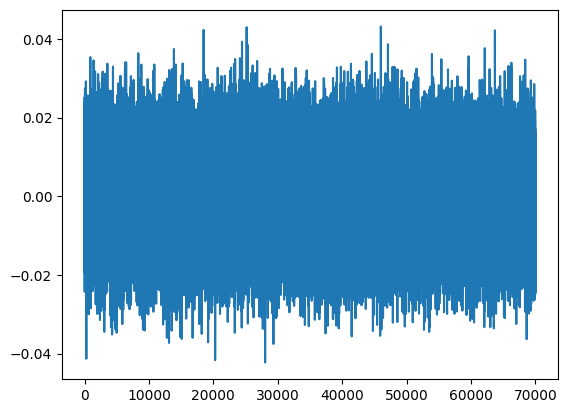

In [4]:
plt.plot(data[0, :])

In [125]:
norm_win_spectra, frequencies = f.normalised_windowed_spectra(
    data, win_len, overlap, sample_interval=1 / samples_per_sec
)

In [126]:
num_frames = norm_win_spectra.shape[0]
sim_eig_ratios_coherence_svd = np.empty(num_frames)
sim_eig_ratios_coherence_qr = np.empty(num_frames)

for d in range(1, num_frames):
    # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
    S = np.linalg.svd(
        norm_win_spectra[d],
        compute_uv=False,
        hermitian=False,
    )
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    sim_eig_ratios_coherence_svd[d] = np.max(svd_approx2) / np.sum(svd_approx2)

    Q, R = np.linalg.qr(norm_win_spectra[d])
    # RRH = R @ (np.matrix(R).H)
    # diag is of sqrt(RR^*)
    # qr_approx2 = np.power(np.diag(RRH), 1)
    qr_approx2 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
    sim_eig_ratios_coherence_qr[d] = np.max(qr_approx2) / np.sum(qr_approx2)

Text(0.5, 0, 'Frequency (Hz)')

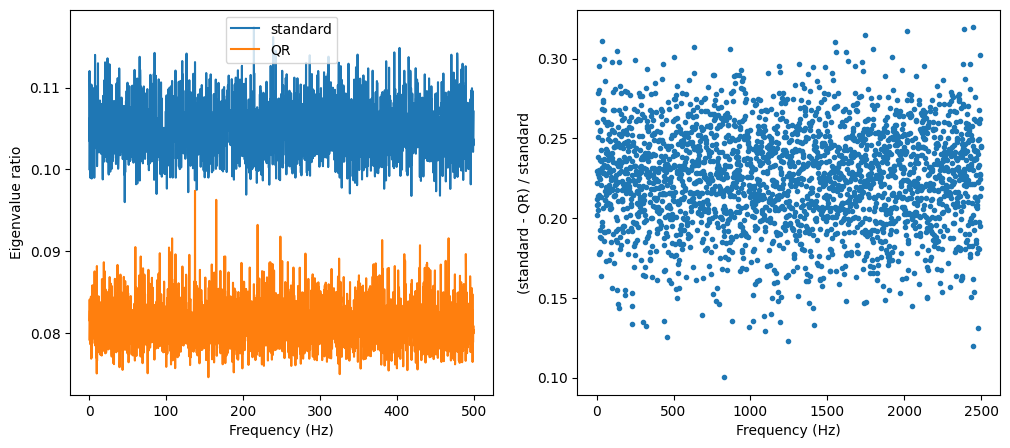

In [127]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(
    frequencies[1:],
    sim_eig_ratios_coherence_svd[1:],
    label="standard",
)
plt.plot(
    frequencies[1:],
    sim_eig_ratios_coherence_qr[1:],
    label="QR",
)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Eigenvalue ratio")
# plt.title("Eigenvalue ratio of coherence matrix")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(
    (sim_eig_ratios_coherence_svd[1:] - sim_eig_ratios_coherence_qr[1:])
    / sim_eig_ratios_coherence_svd[1:],
    ".",
)
# plt.plot((eig_ratios_coherence[1:] - eig_ratios_coherence_qr[1:]), ".")
plt.ylabel("(standard - QR) / standard")
plt.xlabel("Frequency (Hz)")

Text(0.5, 0, 'Relative difference')

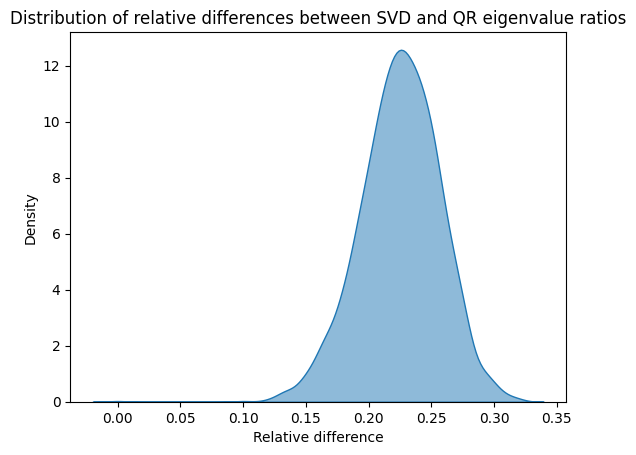

In [128]:
sns.kdeplot(
    (sim_eig_ratios_coherence_svd - sim_eig_ratios_coherence_qr)
    / sim_eig_ratios_coherence_svd,
    fill=True,
    alpha=0.5,
)
plt.title(
    "Distribution of relative differences between SVD and QR eigenvalue ratios"
)
plt.xlabel("Relative difference")

In [9]:
# threshold_u = 0.3
# threshold_d = 0.1

# max_norms_events, other_norms_events, max_norms_noise, other_norms_noise = get_norm_parameters(
#     eig_ratios_coherence, norm_win_spectra, threshold_u, threshold_d, qr=False
# )
# ratios_events = np.array(max_norms_events) / np.array(other_norms_events)
# ratios_noise = np.array(max_norms_noise) / np.array(other_norms_noise)

# plt.figure(figsize=(16, 5))
# plt.subplot(1, 3, 1)
# plt.plot(max_norms_events, other_norms_events, "o--", label="events")
# plt.plot(max_norms_noise, other_norms_noise, "o--", label="noise", alpha=0.5)
# plt.title("Events")
# plt.xlabel("Max norm")
# plt.ylabel("Other norms")
# plt.legend()
# plt.subplot(1, 3, 2)
# plt.plot(max_norms_noise, other_norms_noise, "o--")
# plt.title("Noise")
# plt.xlabel("Max norm")
# plt.ylabel("Other norms")
# plt.subplot(1, 3, 3)

In [10]:
start_channel = 1300
end_channel = 3300

In [11]:
basepath = Path("D:\CSM\Mines_Research\Test_data\Brady_Hotspring")
files = [
    "PoroTomo_iDAS16043_160314083818.h5",
    "PoroTomo_iDAS16043_160314083848.h5",
    "PoroTomo_iDAS16043_160314083918.h5",
]
file = basepath / files[1]

real_data, _ = f.load_brady_hdf5(file, normalize="no")
real_data = real_data[
    start_channel : end_channel : int((end_channel - start_channel) / nsensors)
]

In [12]:
file = basepath / files[0]
print(f"Loading {file}")
real_data, _ = f.load_brady_hdf5(file, normalize="no")
real_data = real_data[
    start_channel : end_channel : int((end_channel - start_channel) / nsensors)
]

file = basepath / files[1]
print(f"Loading {file}")
data2, _ = f.load_brady_hdf5(file, normalize="no")
data2 = data2[
    start_channel : end_channel : int((end_channel - start_channel) / nsensors)
]
real_data = np.append(real_data, data2, axis=1)

file = basepath / files[2]
print(f"Loading {file}")
data2, _ = f.load_brady_hdf5(file, normalize="no")
data2 = data2[
    start_channel : end_channel : int((end_channel - start_channel) / nsensors)
]
real_data = np.append(real_data, data2[:, :10000], axis=1)

Loading D:\CSM\Mines_Research\Test_data\Brady_Hotspring\PoroTomo_iDAS16043_160314083818.h5
Loading D:\CSM\Mines_Research\Test_data\Brady_Hotspring\PoroTomo_iDAS16043_160314083848.h5
Loading D:\CSM\Mines_Research\Test_data\Brady_Hotspring\PoroTomo_iDAS16043_160314083918.h5


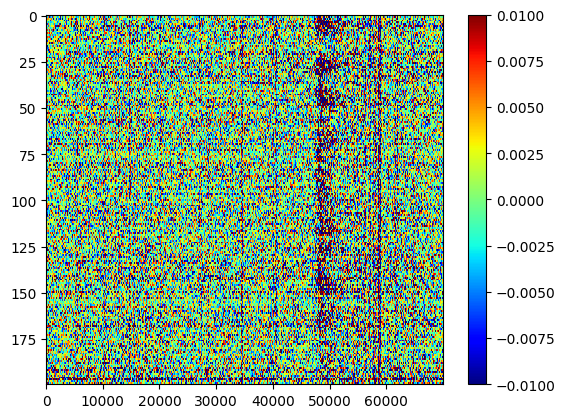

In [15]:
plt.imshow(
    real_data,
    aspect="auto",
    interpolation="none",
    cmap="jet",
    vmin=-0.01,
    vmax=0.01,
    # extent=[0, 70000, 0, nsensors],
)
plt.colorbar()

In [13]:
norm_win_spectra, frequencies = f.normalised_windowed_spectra(
    real_data, win_len, overlap, sample_interval=1 / samples_per_sec
)
welch_coherence_mat = np.matmul(
    norm_win_spectra, np.conjugate(norm_win_spectra.transpose(0, 2, 1))
)
welch_coherence_mat2 = f.welch_coherence(
    real_data,
    win_len,
    overlap,
    freq=None,
    sample_interval=1/samples_per_sec,
)

In [14]:
num_frames = norm_win_spectra.shape[0]
eig_ratios_coherence = np.empty(num_frames)
eig_ratios_coherence_qr = np.empty(num_frames)

for d in range(1, num_frames):
    # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
    S = np.linalg.svd(
        norm_win_spectra[d],
        compute_uv=False,
        hermitian=False,
    )
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    eig_ratios_coherence[d] = np.max(svd_approx2) / np.sum(svd_approx2)

    Q, R = np.linalg.qr(norm_win_spectra[d])
    # RRH = R @ (np.matrix(R).H)
    # diag is of sqrt(RR^*)
    # qr_approx2 = np.power(np.diag(RRH), 1)
    qr_approx2 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
    eig_ratios_coherence_qr[d] = np.max(qr_approx2) / np.sum(qr_approx2)

In [49]:
method = "qr"
eig_ratios_coherence_qr, eig_estimates_qr, frequencies = f.coherence(
    real_data,
    win_len,
    overlap,
    sample_interval=1 / samples_per_sec,
    method=method,
    max_freq=300,
)
method = "svd"
eig_ratios_coherence_svd, eig_estimates_svd, frequencies = f.coherence(
    real_data,
    win_len,
    overlap,
    sample_interval=1 / samples_per_sec,
    method=method,
    max_freq=300,
)
method = "exact"
eig_ratios_coherence, eig_estimates, frequencies = f.coherence(
    real_data,
    win_len,
    overlap,
    sample_interval=1 / samples_per_sec,
    method=method,
    max_freq=300,
)
# eig_ratios_coherence_ratio = eig_ratios_coherence/eig_ratios_coherence_qr

In [111]:
detection3_svd = np.sum(eig_estimates_svd[:,:4], axis=1)/np.sum(eig_estimates_svd, axis=1)
sorted_eig_qr = np.sort(eig_estimates_qr, axis=1)
detection3_qr = np.sum(sorted_eig_qr[:,-4:], axis=1)/np.sum(sorted_eig_qr, axis=1)

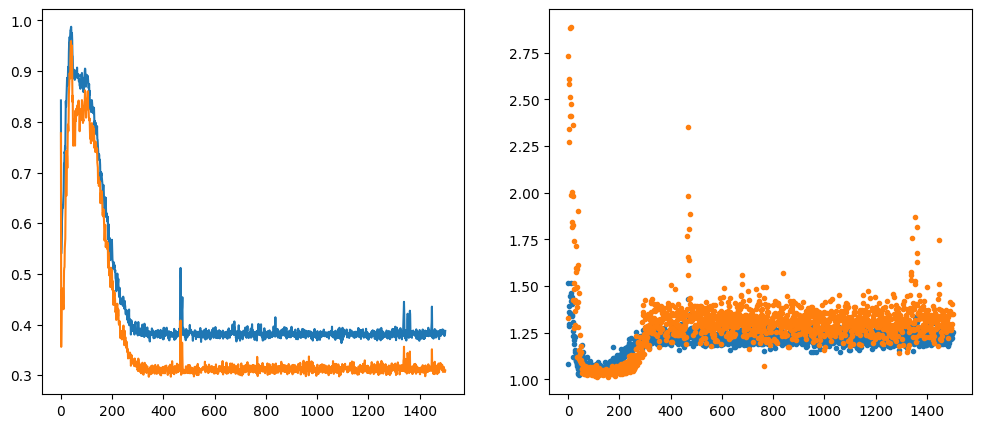

In [112]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(detection3_svd)
plt.plot(detection3_qr)
plt.subplot(1, 2, 2)
plt.plot(detection3_svd/detection3_qr, ".")
plt.plot(eig_ratios_coherence_svd/eig_ratios_coherence_qr, ".")
# eig_estimates_svd[:,:2].shape

Text(0, 0.5, '(standard - QR) / standard ')

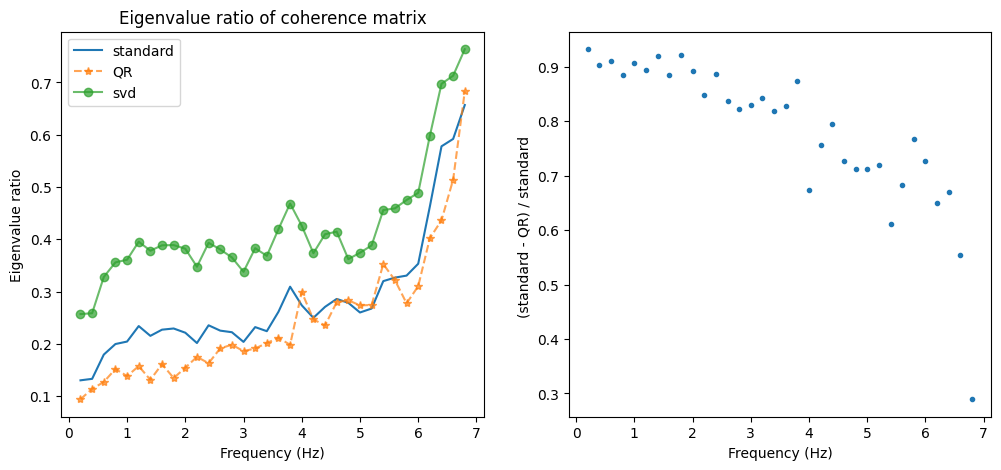

In [129]:
flim = 35
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(
    frequencies[1:flim],
    eig_ratios_coherence[1:flim],
    label="standard",
)
plt.plot(
    frequencies[1:flim],
    eig_ratios_coherence_qr[1:flim], "*--",
    label="QR",
    alpha=0.7,
)
plt.plot(
    frequencies[1:flim],
    eig_ratios_coherence_svd[1:flim], "o-",
    label="svd",
    alpha=0.7,
)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Eigenvalue ratio")
plt.title("Eigenvalue ratio of coherence matrix")
plt.legend()

plt.subplot(1, 2, 2)
# plt.plot((eig_ratios_coherence[1:400] - eig_ratios_coherence_qr[1:400]), ".")
plt.plot(
    frequencies[1:flim],
    (eig_ratios_coherence[1:flim] - eig_ratios_coherence_qr[1:flim]**2)
    / eig_ratios_coherence[1:flim],
    ".",
)
plt.xlabel("Frequency (Hz)")
plt.ylabel("(standard - QR) / standard ")

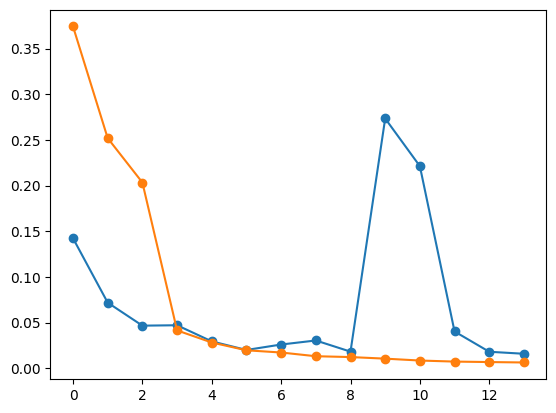

In [156]:
f_index = 25
plt.plot(eig_estimates_qr[f_index]/np.sum(eig_estimates_qr[f_index]), "o-")
plt.plot(eig_estimates_svd[f_index]/np.sum(eig_estimates_svd[f_index]), "o-")

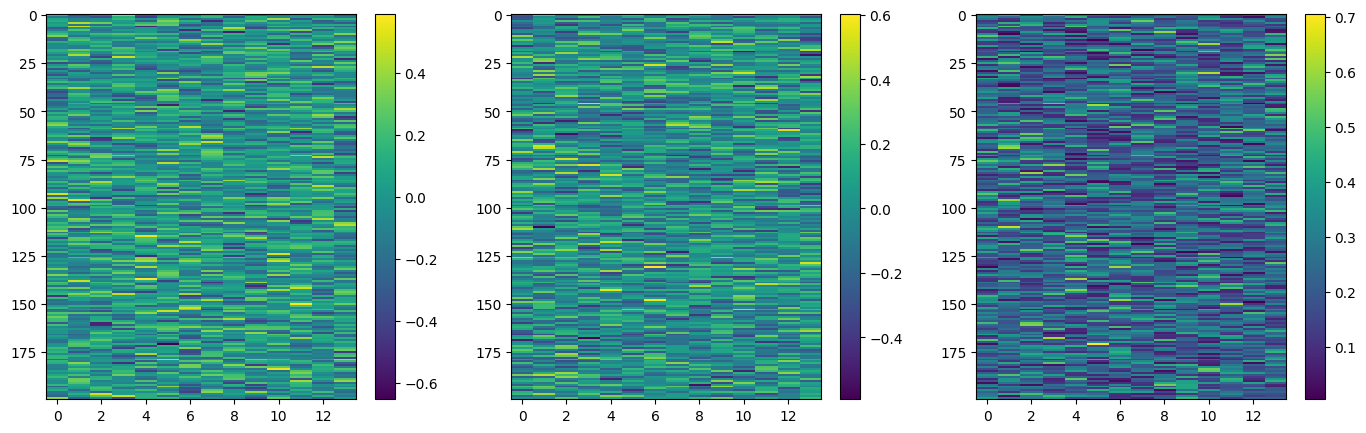

In [143]:
ind = 26
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
plt.imshow(
    norm_win_spectra[ind].real,
    aspect="auto",
    interpolation="none",
    # extent=[0, 70000, 0, nsensors],
)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(
    norm_win_spectra[ind].imag,
    aspect="auto",
    interpolation="none",
    # extent=[0, 70000, 0, nsensors],
)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(
    np.abs(norm_win_spectra[ind]),
    aspect="auto",
    interpolation="none",
    # extent=[0, 70000, 0, nsensors],
)
plt.colorbar()

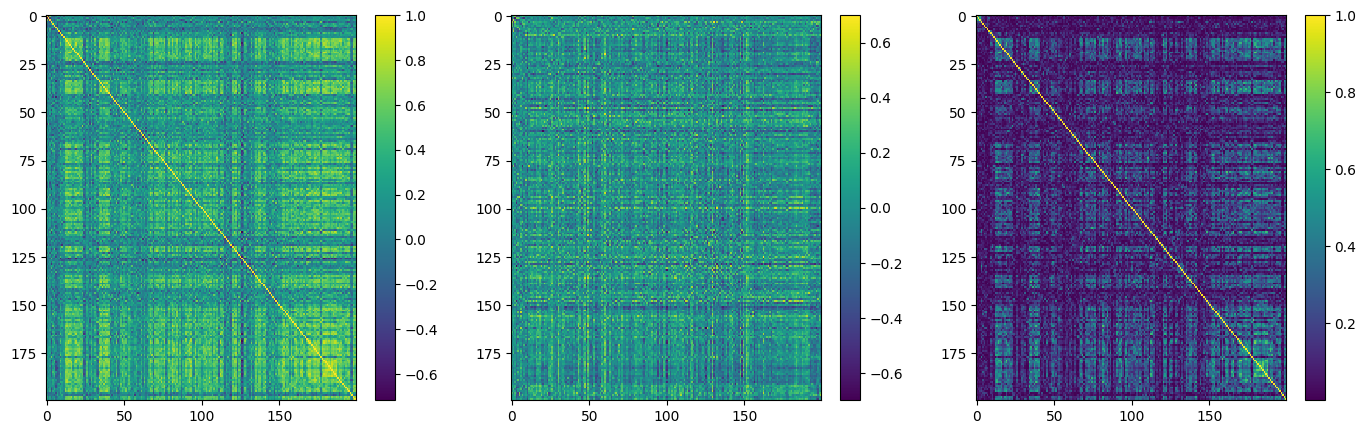

In [19]:
ind = 4
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
plt.imshow(
    welch_coherence_mat[ind].real,
    aspect="auto",
    interpolation="none",
    # extent=[0, 70000, 0, nsensors],
)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(
    welch_coherence_mat[ind].imag,
    aspect="auto",
    interpolation="none",
    # extent=[0, 70000, 0, nsensors],
)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(
    np.abs(welch_coherence_mat[ind])**2,
    aspect="auto",
    interpolation="none",
    # extent=[0, 70000, 0, nsensors],
)
plt.colorbar()

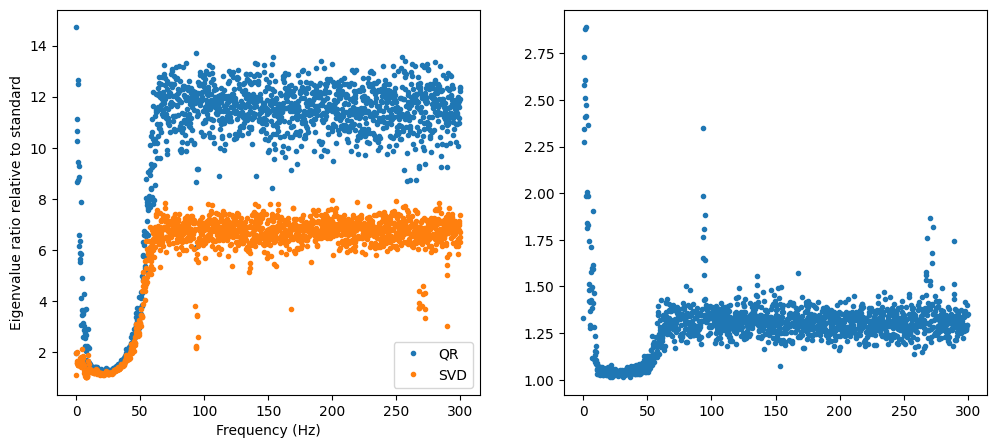

In [20]:
# plt.plot(eig_ratios_coherence[460:flim], ".")
# plt.plot(eig_ratios_coherence[1:200], ".")
# plt.plot(eig_ratios_coherence[1:50] / eig_ratios_coherence_qr[1:50], ".")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(frequencies, eig_ratios_coherence/eig_ratios_coherence_qr**2, ".", label="QR")
plt.plot(frequencies, eig_ratios_coherence/eig_ratios_coherence_svd**2, ".", label="SVD")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Eigenvalue ratio relative to standard")
plt.legend()
plt.subplot(1, 2, 2)
# plt.plot(frequencies, eig_ratios_coherence_svd**2/eig_ratios_coherence_qr**2, ".", label="QR")
plt.plot(frequencies, eig_ratios_coherence_svd/eig_ratios_coherence_qr, ".", label="QR")

Text(0.5, 0, 'Snapshot in time')

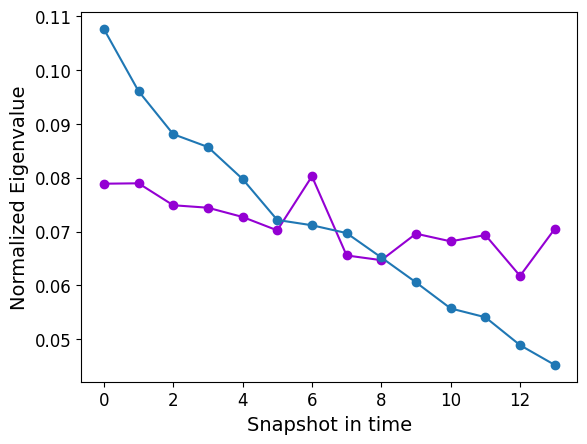

In [142]:
tick_size = 12
fsize = 14

freq_i = 26
RandA = norm_win_spectra[freq_i, :, :]
R1 = np.linalg.qr(RandA, mode="r")
qr_ = np.diag(R1 @ np.conjugate(R1.transpose()))
plt.plot(qr_ / np.sum(qr_), "-o", color="darkviolet")
# plt.plot(qr / np.sum(qr), "-*", color="goldenrod")

S = np.linalg.svd(norm_win_spectra[freq_i], compute_uv=False, hermitian=False)
svd_approx2 = np.sort(S)[::-1] **2
plt.plot(
    np.sort(svd_approx2 / np.sum(svd_approx2))[::-1],
    # np.sort(eigenvals2 / np.sum(eigenvals2))[::-1],
    "-o",
    label="14 Hz",
)


plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylabel("Normalized Eigenvalue", fontsize=fsize)
# plt.ylabel(r"$\frac{d_i}{\sum_{i=1}^{n} d_i}$", fontsize=fsize, rotation="horizontal",
#     labelpad=20,
#     )
plt.xlabel("Snapshot in time", fontsize=fsize)
# plt.ylim(0, 0.9)

Text(0.5, 0, '$\\frac{\\lambda_1 - \\overline{\\lambda_1}}{\\lambda_1}$')

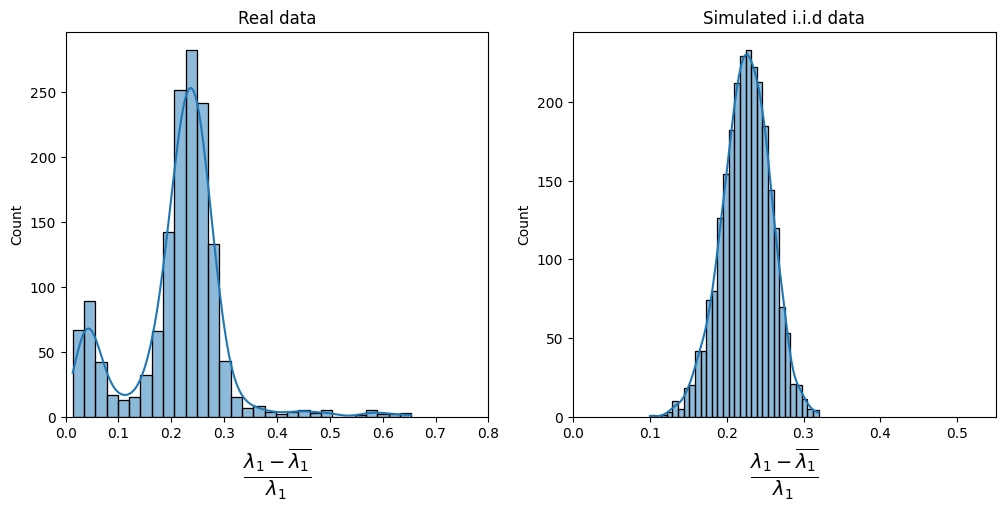

In [132]:
flim = 1500
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(
    (eig_ratios_coherence_svd[1:flim] - eig_ratios_coherence_qr[1:flim])
    / eig_ratios_coherence_svd[1:flim],
    kde=True,
    fill=True,
    alpha=0.5,
    bins=30,
)
plt.title("Real data")
plt.xlim([0, 0.8])
plt.xlabel(
    r"$\frac{\lambda_1 - \overline{\lambda_1}}{\lambda_1}$", fontsize=20
)

plt.subplot(1, 2, 2)
sns.histplot(
    (sim_eig_ratios_coherence_svd[1:] - sim_eig_ratios_coherence_qr[1:])
    / sim_eig_ratios_coherence_svd[1:],
    kde=True,
    fill=True,
    alpha=0.5,
    bins=30,
)
plt.title("Simulated i.i.d data")
plt.xlim([0, 0.55])
plt.xlabel(
    r"$\frac{\lambda_1 - \overline{\lambda_1}}{\lambda_1}$", fontsize=20
)

(1.0, 3.0)

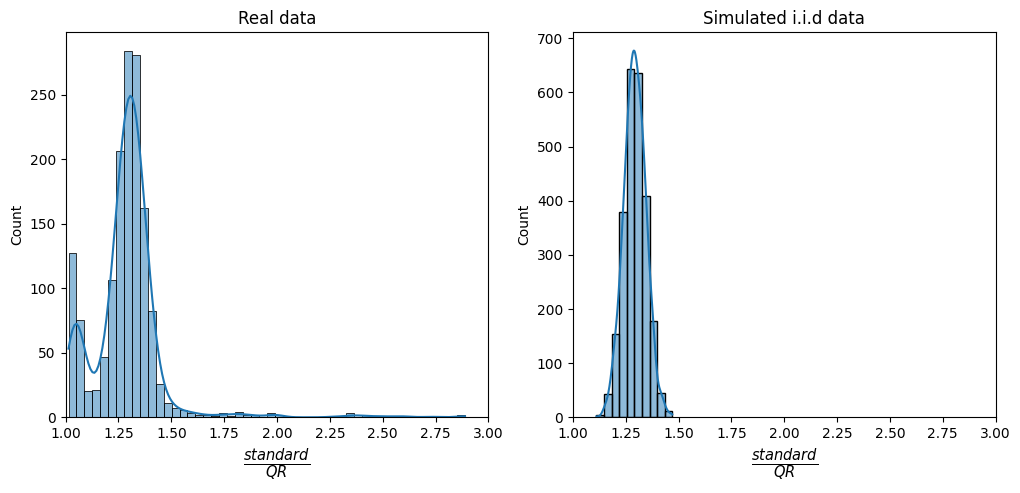

In [134]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(
    (eig_ratios_coherence_svd[1:flim]) / eig_ratios_coherence_qr[1:flim],
    kde=True,
    fill=True,
    alpha=0.5,
    bins=50,
)
plt.title("Real data")
# plt.xlim([1, 5])
# plt.xlabel(r"$\frac{\lambda_1}{\max_i (d_i)}$", fontsize=15)
plt.xlabel(r"$\frac{standard}{QR}$", fontsize=15)
plt.xlim([1, 3])

plt.subplot(1, 2, 2)
sns.histplot(
    (sim_eig_ratios_coherence_svd[1:]) / sim_eig_ratios_coherence_qr[1:],
    kde=True,
    fill=True,
    alpha=0.5,
    bins=10,
)
plt.title("Simulated i.i.d data")
# plt.xlim([1, 5])
# plt.xlabel(r"$\frac{\lambda_1}{\max_i (d_i)}$", fontsize=15)
plt.xlabel(r"$\frac{standard}{QR}$", fontsize=15)
plt.xlim([1, 3])

[None, None]

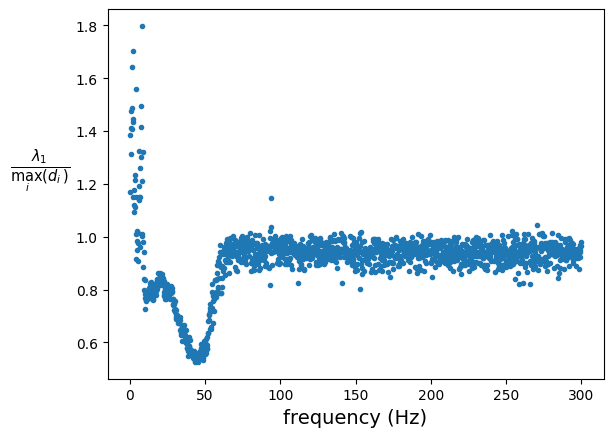

In [24]:
plt.plot(
    frequencies[1:flim],
    (eig_ratios_coherence[1:flim]) / eig_ratios_coherence_qr[1:flim],
    ".",
)
# plt.title("Simulated i.i.d data")
# plt.xlim([1, 5])
plt.ylabel(r"$\frac{\lambda_1}{\max_i (d_i)}$", fontsize=15)
plt.xlabel("frequency (Hz)", fontsize=14)
plt.gca().yaxis.label.set(rotation="horizontal", ha="right")

[None, None]

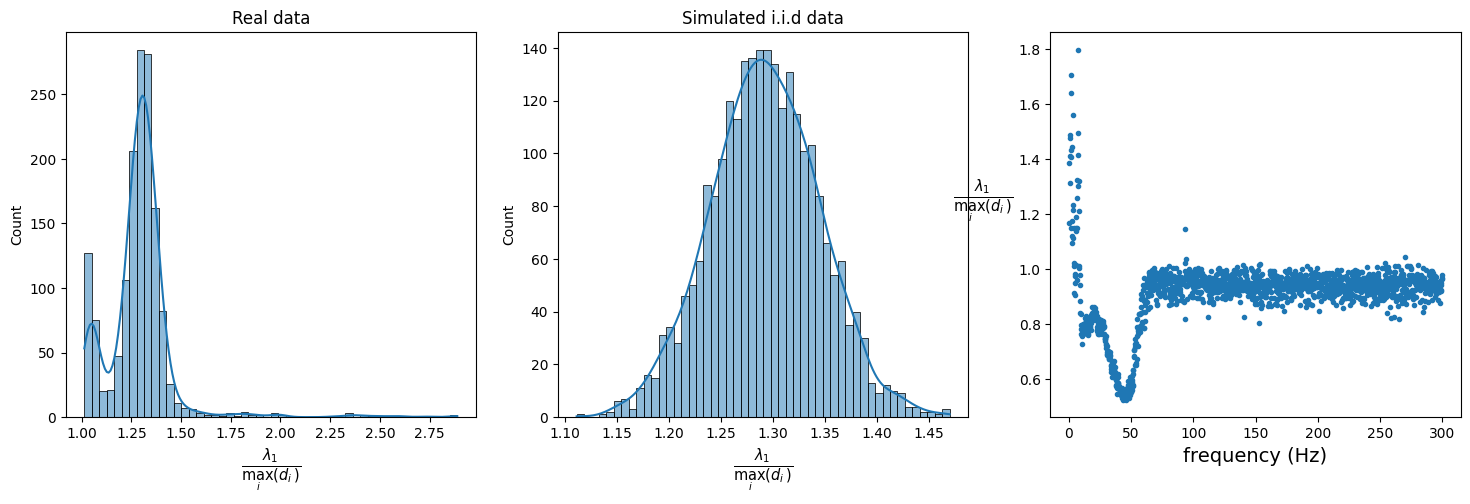

In [135]:
flim = 1500
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.histplot(
    (eig_ratios_coherence_svd[1:flim]) / eig_ratios_coherence_qr[1:flim],
    kde=True,
    fill=True,
    alpha=0.5,
    bins=50,
)
plt.title("Real data")
# plt.xlim([1, 5])
plt.xlabel(r"$\frac{\lambda_1}{\max_i (d_i)}$", fontsize=15)

plt.subplot(1, 3, 2)
sns.histplot(
    (sim_eig_ratios_coherence_svd[1:]) / sim_eig_ratios_coherence_qr[1:],
    kde=True,
    fill=True,
    alpha=0.5,
    bins=50,
)
plt.title("Simulated i.i.d data")
# plt.xlim([1, 5])
plt.xlabel(r"$\frac{\lambda_1}{\max_i (d_i)}$", fontsize=15)

plt.subplot(1, 3, 3)
plt.plot(
    frequencies[1:flim],
    (eig_ratios_coherence[1:flim]) / eig_ratios_coherence_qr[1:flim],
    ".",
)
# plt.title("Simulated i.i.d data")
# plt.xlim([1, 5])
plt.ylabel(r"$\frac{\lambda_1}{\max_i (d_i)}$", fontsize=15)
plt.xlabel("frequency (Hz)", fontsize=14)
plt.gca().yaxis.label.set(rotation="horizontal", ha="right")

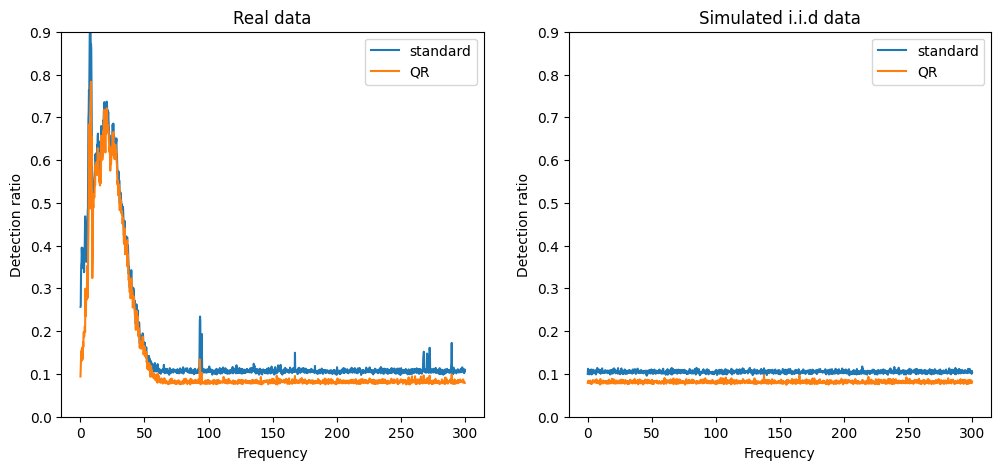

In [136]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(frequencies[1:flim], eig_ratios_coherence_svd[1:flim], label="standard")
plt.plot(frequencies[1:flim], eig_ratios_coherence_qr[1:flim], label="QR")
# plt.plot(eig_ratios_coherence[185:192], label="Exact")
# plt.plot(eig_ratios_coherence_qr[185:192], label="QR")
plt.title("Real data")
plt.ylabel("Detection ratio")
plt.xlabel("Frequency")
# plt.xlabel(r"$\frac{\lambda_1 - \overline{\lambda_1}}{\lambda_1}$", fontsize=20)
plt.ylim(0, 0.9)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(
    frequencies[1:flim], sim_eig_ratios_coherence_svd[1:flim], label="standard"
)
plt.plot(frequencies[1:flim], sim_eig_ratios_coherence_qr[1:flim], label="QR")
plt.title("Simulated i.i.d data")
# plt.ylabel(r"$\frac{\lambda_1}{\sum \lambda_n}$", fontsize=20)
plt.ylabel("Detection ratio")
plt.xlabel("Frequency")
plt.ylim(0, 0.9)
plt.legend()
# plt.xlabel(r"$\frac{\lambda_1 - \overline{\lambda_1}}{\lambda_1}$", fontsize=20)

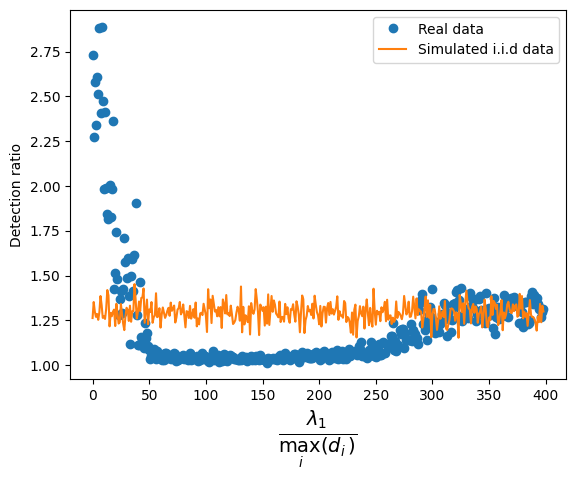

In [137]:
plt.plot(
    (eig_ratios_coherence_svd[1:400]) / eig_ratios_coherence_qr[1:400],
    "o",
    label="Real data",
)
plt.plot(
    (sim_eig_ratios_coherence_svd[1:400]) / sim_eig_ratios_coherence_qr[1:400],
    label="Simulated i.i.d data",
)
plt.xlabel(r"$\frac{\lambda_1}{\max_i (d_i)}$", fontsize=20)
plt.ylabel("Detection ratio")
plt.legend()

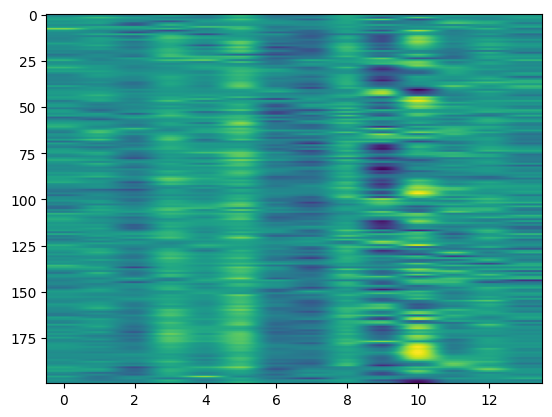

In [28]:
plt.imshow(norm_win_spectra[16].real, aspect="auto")

In [29]:
frequencies[16]

3.2

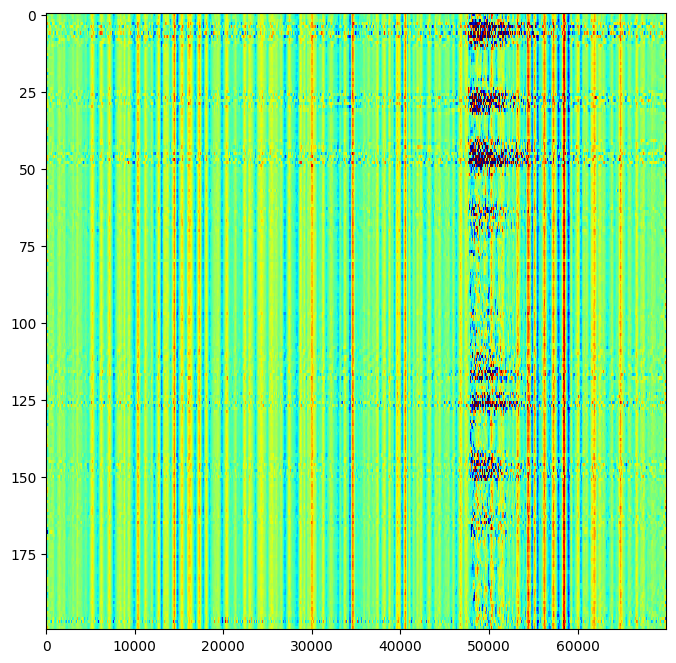

In [30]:
# filtered_data = f.frequency_filter(real_data, 6, "lowpass", 2, samples_per_sec)
# filtered_data = f.frequency_filter(real_data, 50, "highpass", 2, samples_per_sec)
filtered_data = f.frequency_filter(
    real_data, [1, 10], "bandpass", 2, samples_per_sec
)
plt.figure(figsize=(8, 8))
plt.imshow(
    filtered_data,
    aspect="auto",
    interpolation="none",
    cmap="jet",
    vmin=-0.01,
    vmax=0.01,
    # extent=[0, 70000, 0, nsensors],
)

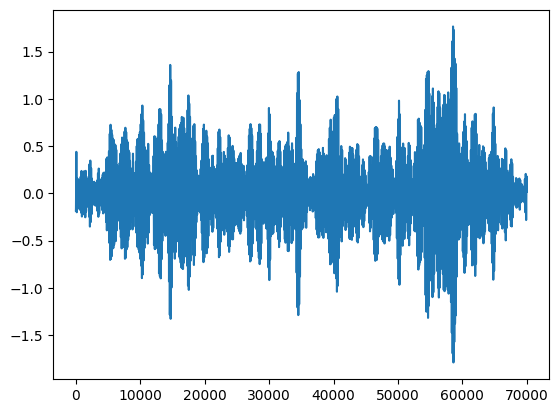

In [31]:
plt.plot(np.sum(filtered_data, axis=0), label="Filtered data")

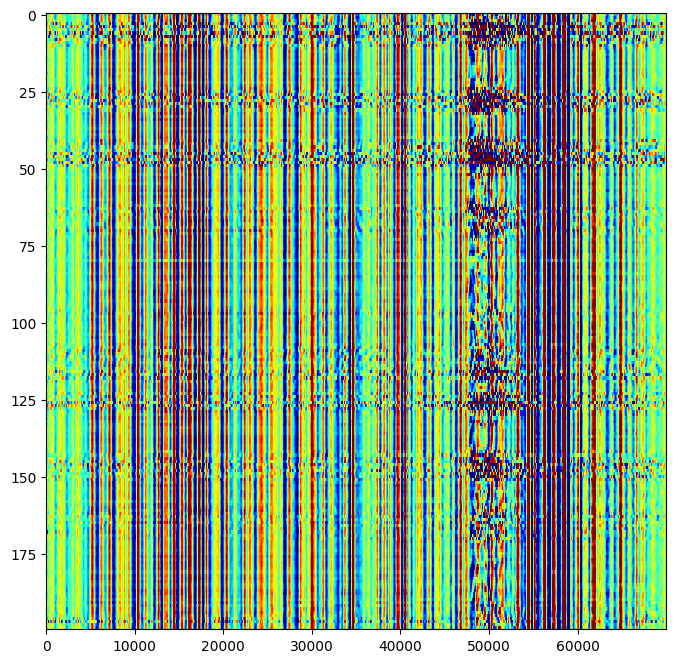

In [32]:
filtered_data = f.frequency_filter(
    real_data, [6, 9], "bandpass", 2, samples_per_sec
)
# filtered_data = f.frequency_filter(real_data, 9, "lowpass", 2, samples_per_sec)
plt.figure(figsize=(8, 8))
plt.imshow(
    filtered_data,
    aspect="auto",
    interpolation="none",
    cmap="jet",
    vmin=-0.004,
    vmax=0.004,
    # extent=[0, 70000, 0, nsensors],
)